> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

###### I have selected the Soccer Database. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016.

###### Here are some of questions I wish to explore

1.What team attributes lead to the most victories

2.Characteristics of top performers.

In [29]:
import matplotlib
import csv
import numpy as np
import pandas as pd
import sqlite3
from pandas import DataFrame as df
import datetime
from random import randint
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vibhuti\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [30]:
db = sqlite3.connect('database.sqlite')

def table_values(table_name):
    df = pd.read_sql("SELECT * FROM "+table_name,db)
    return df
db.close;
    
country_list_original = table_values('Country')
league_list_original = table_values('League')
match_list_original = table_values('Match')
player_list_original = table_values('Player')
playerattributes_list_original = table_values('Player_Attributes')
team_list_original = table_values('Team')
teamattributes_list_original = table_values('Team_Attributes')

### Data Cleaning (Replace this with more specific notes!)

In [31]:
print("checking if the country id and league id in matches table are correct:")
print(set(match_list_original['league_id'])^set(league_list_original['id']))
print(set(match_list_original['country_id'])^set(country_list_original['id']))



print("checking if the match entries are unique")
print(match_list_original.shape[0]==match_list_original.loc[:, ['stage', 'date','home_team_api_id', 'away_team_api_id']].drop_duplicates().shape[0])



print("Number of team long and short name combinations who have more than one team id:")
print(all(value == 0 for value in pd.DataFrame(team_list_original, columns=["team_long_name","team_short_name"]).groupby(['team_long_name','team_short_name']).size().to_dict()
.values()))

print("Number of teams whose attributes we dont have:")
team_apiid_diff = set(team_list_original['team_api_id'])^set(teamattributes_list_original['team_api_id'])
for entry in team_apiid_diff:
    team_list_original = team_list_original[team_list_original.team_api_id !=entry]
team_apiid_diff = set(team_list_original['team_api_id'])^set(teamattributes_list_original['team_api_id'])
print(team_apiid_diff)

print("Number of players whose attributes we dont have:")
player_apiid_diff = set(player_list_original['player_api_id'])^set(playerattributes_list_original['player_api_id'])
for entry in player_apiid_diff:
    player_list_original = player_list_original[player_list_original.player_api_id !=entry]
print(player_apiid_diff)

checking if the country id and league id in matches table are correct:
set()
set()
checking if the match entries are unique
True
Number of team long and short name combinations who have more than one team id:
<generator object <genexpr> at 0x0000019936528AF0>
Number of teams whose attributes we dont have:
set()
Number of players whose attributes we dont have:
set()


In [32]:
#removing unwanted fields

def remove_unwanted_columns(table_name,columns_to_keep):
    table_name.drop(np.delete(table_name.columns, columns_to_keep),inplace=True,axis=1,errors='ignore')

remove_unwanted_columns(match_list_original,range(1,55))
remove_unwanted_columns(teamattributes_list_original,[0,1,2,3,4,6,8,11,13,15,18,20,22])

In [33]:
#removing rows/columns with null values

pd.isnull(country_list_original).sum() > 0
#country table has no null values

pd.isnull(league_list_original).sum() > 0
#league table has no null values

pd.isnull(match_list_original).sum() > 0
#the xy coordinates do contain certain null values but I am going to keep this as Ill want to do some computation

pd.isnull(player_list_original).sum() > 0
#player table has no null values

pd.isnull(playerattributes_list_original).sum() > 0 
playerattributes_list_original.shape[0] - playerattributes_list_original[playerattributes_list_original.isnull().any(axis=1)].shape[0]
#180354 rows contain not null values, we will drop the other rows for player investgation

pd.isnull(team_list_original).sum() > 0
# team_fifa_api_id contains null.will drop that column

pd.isnull(teamattributes_list_original).sum() > 0
# buildUpPlayDribbling contains null. will drop that column

team_list_original = team_list_original.dropna(axis=1, how='any')
playerattributes_list_original = playerattributes_list_original.dropna(axis=0, how='any')
teamattributes_list_original = teamattributes_list_original.dropna(axis=1, how='any')

In [34]:
#convert string to datetime

match_list_original['date'] = pd.to_datetime(match_list_original['date'])
playerattributes_list_original['date'] = pd.to_datetime(playerattributes_list_original['date'])
teamattributes_list_original['date'] = pd.to_datetime(teamattributes_list_original['date'])

<a id='eda'></a>
## Exploratory Data Analysis

## Question 1: What team attributes lead to the most victories

In [35]:
# function returns matches won by each team

def get_team_wins(year):
    
    match_list_by_year = match_list_original[match_list_original['date']>datetime.date(year,1,1)]
    match_list_by_year['win'] = np.where(match_list_by_year['home_team_goal']>match_list_by_year['away_team_goal'], 
                             match_list_by_year['home_team_api_id'],
                             (np.where(match_list_by_year['home_team_goal']<match_list_by_year['away_team_goal'],
                                       match_list_by_year['away_team_api_id'],
                                       0)))
    team_win_count = (pd.DataFrame({'team_api_id':list(match_list_by_year['win'])}))['team_api_id'].value_counts()
    team_win_df = pd.DataFrame({'team_api_id':team_win_count.index, 'win':team_win_count.values})[1:]
    return team_win_df

In [36]:
# function returns away matches won by each team

def get_team_away_wins(year):
    match_list_awaywin_by_year = match_list_original[match_list_original['date']>datetime.date(year,1,1)]
    match_list_awaywin_by_year['away_win'] = np.where(match_list_awaywin_by_year['home_team_goal']<match_list_awaywin_by_year['away_team_goal'],
                                       match_list_awaywin_by_year['away_team_api_id'],
                                       0)
    team_win_away_count = (pd.DataFrame({'team_api_id':list(match_list_awaywin_by_year['away_win'])}))['team_api_id'].value_counts()
    team_win_away_df = pd.DataFrame({'team_api_id':team_win_away_count.index, 'away_win':team_win_away_count.values})[1:]
    return team_win_away_df

In [37]:
teamattributes_list_2015 = teamattributes_list_original[teamattributes_list_original['date']>datetime.date(2015,1,1)]
teamattributes_for_teaminfo = teamattributes_list_2015.merge(team_list_original,on="team_api_id",how='inner')
teamattributes_for_wins = teamattributes_for_teaminfo.merge(get_team_wins(2015),on="team_api_id",how='inner')
teamattributes_for_awaywins = teamattributes_for_wins.merge(get_team_away_wins(2015),on="team_api_id",how='inner')
teamattributes_list = teamattributes_for_awaywins.rename(columns={c: c.replace('_y', '') for c in teamattributes_for_awaywins.columns})
teamattributes_list = teamattributes_list.rename(columns={c: c.replace('_x', '') for c in teamattributes_list.columns})
teamattributes_list = teamattributes_list.T.groupby(level=0).first().T

teamattributes_list = teamattributes_list.sort_values(['win'], ascending=[False])

teamattributes_list['date'] = pd.to_datetime(teamattributes_list['date'])

C:\Users\Vibhuti\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vibhuti\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
# converting columnvalues to numeric.doing it individually for very column as python giving an error

teamattributes_list[['buildUpPlaySpeed']] = teamattributes_list[['buildUpPlaySpeed']].apply(pd.to_numeric)
teamattributes_list[['win']] = teamattributes_list[['win']].apply(pd.to_numeric)
teamattributes_list[['away_win']] = teamattributes_list[['win']].apply(pd.to_numeric)
teamattributes_list[['buildUpPlayPassing']] = teamattributes_list[['buildUpPlayPassing']].apply(pd.to_numeric)
teamattributes_list[['chanceCreationPassing']] = teamattributes_list[['chanceCreationPassing']].apply(pd.to_numeric)
teamattributes_list[['chanceCreationCrossing']] = teamattributes_list[['chanceCreationCrossing']].apply(pd.to_numeric)
teamattributes_list[['chanceCreationShooting']] = teamattributes_list[['chanceCreationShooting']].apply(pd.to_numeric)
teamattributes_list[['defencePressure']] = teamattributes_list[['defencePressure']].apply(pd.to_numeric)
teamattributes_list[['defenceAggression']] = teamattributes_list[['defenceAggression']].apply(pd.to_numeric)
teamattributes_list[['defenceTeamWidth']] = teamattributes_list[['defenceTeamWidth']].apply(pd.to_numeric)


df_top5_2015 = teamattributes_list.head(5)


Team attributes for top 5 teams


Text(0,0.5,'Attribute values')

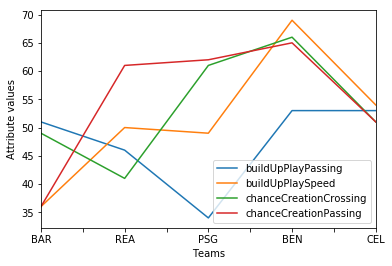

In [39]:
print("Team attributes for top 5 teams")
                          
def get_teamdata_for_attribute(attribute):
    column_list = list(teamattributes_list.columns.values)[1:5]
    index = df_top5_2015['team_short_name'].values
    value = df_top5_2015[column_list].values
    df_PlaySpeed = pd.DataFrame(value, index=index, columns=column_list)
    return df_PlaySpeed

plot_teamattributes = get_teamdata_for_attribute('buildUpPlaySpeed').plot()
plot_teamattributes.set_xlabel("Teams")
plot_teamattributes.set_ylabel("Attribute values")

In [40]:
def plot_team_attribute_win(attribute):
    df = teamattributes_list.groupby('team_api_id').mean().sort_values(['win'], ascending=[False])
    df_standardised = (df - df.mean())/df.std()
    index = df_standardised['win'].values
    value = df_standardised[attribute].values
    df_PlaySpeed = pd.DataFrame(value, index=index, columns=[attribute])
    return df_PlaySpeed

Text(0,0.5,'Standardised buildUpPlaySpeed values')

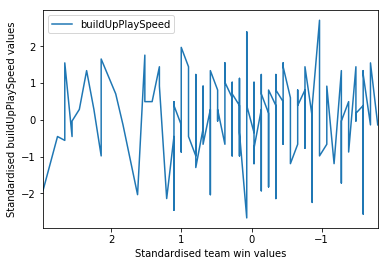

In [41]:
plot_buildplayspeed = plot_team_attribute_win('buildUpPlaySpeed').plot()
plot_buildplayspeed.set_xlabel("Standardised team win values")
plot_buildplayspeed.set_ylabel("Standardised buildUpPlaySpeed values")

Build up play speed is lower for the top teams

Text(0,0.5,'Standardised defencePressure values')

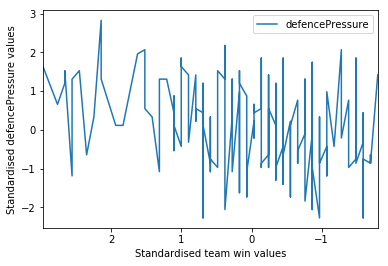

In [42]:
plot_defencePressure = plot_team_attribute_win('defencePressure').plot()
plot_defencePressure.set_xlabel("Standardised team win values")
plot_defencePressure.set_ylabel("Standardised defencePressure values")

The ability to put a defence pressure is higher for the top teams

Text(0,0.5,'Standardised defenceAggression values')

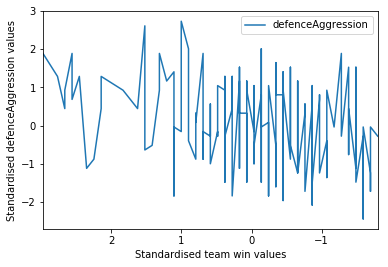

In [43]:
plot_defenceAggression = plot_team_attribute_win('defenceAggression').plot()
plot_defenceAggression.set_xlabel("Standardised team win values")
plot_defenceAggression.set_ylabel("Standardised defenceAggression values")

The ability to put a defence aggression is higher for the top teams

### Characteristics of top performers

In [44]:
playerattributes_list_2016 = playerattributes_list_original[playerattributes_list_original['date']>datetime.date(2016,1,1)]

playerattributes_for_players = playerattributes_list_2016.merge(player_list_original,on="player_api_id",how='inner')
playerattributes_list = playerattributes_for_players.rename(columns={c: c.replace('_y', '') for c in playerattributes_for_players.columns})
playerattributes_list = playerattributes_list.rename(columns={c: c.replace('_x', '') for c in playerattributes_list.columns})
playerattributes_list = playerattributes_list.T.groupby(level=0).first().T
playerattributes_list['date'] = pd.to_datetime(playerattributes_list['date'])
playerattributes_list = playerattributes_list.sort_values(['date'], ascending=[True])
playerattributes_list = playerattributes_list.drop_duplicates(subset='player_api_id', keep='last')
playerattributes_list = playerattributes_list.sort_values(['overall_rating'], ascending=[True])

top_10_players = playerattributes_list[:10]

Player attributes for top ten players


C:\Users\Vibhuti\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0,0.5,'Attribute values')

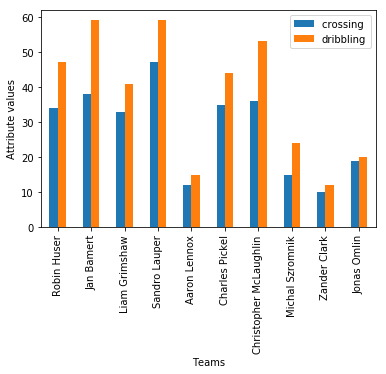

In [45]:
print("Player attributes for top ten players")

def plot_attributes_for_top_10():
    top_10_players.drop(np.delete(top_10_players.columns, [7,11,31]),inplace=True,axis=1,errors='ignore')
    value = top_10_players[['crossing','dribbling']].values
    df_PlaySpeed = pd.DataFrame(value, index=top_10_players['player_name'].values, columns=['crossing ','dribbling'])
    return df_PlaySpeed

plot_top10players = plot_attributes_for_top_10().plot.bar()
plot_top10players.set_xlabel("Teams")
plot_top10players.set_ylabel("Attribute values")

In [46]:
playerattributes_list[['dribbling','crossing','shot_power','penalties']] = playerattributes_list[['dribbling','crossing','shot_power','penalties']].apply(pd.to_numeric)

Text(0,0.5,'Standardised attribute values')

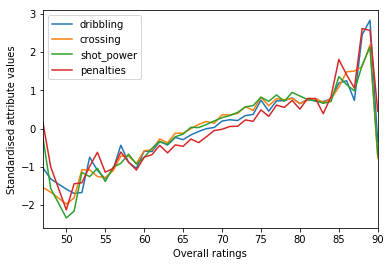

In [47]:
def plot_player_attribute_rating(attribute):
    df = playerattributes_list.groupby('overall_rating').mean()
    df_standardised = (df - df.mean())/df.std()
    value = df_standardised[attribute].values
    df_PlaySpeed = pd.DataFrame(value, index=df_standardised.index, columns=[attribute])
    return df_PlaySpeed

plot_playerattributesbyrating = plot_player_attribute_rating(['dribbling','crossing','shot_power','penalties']).plot()
plot_playerattributesbyrating.set_xlabel("Overall ratings")
plot_playerattributesbyrating.set_ylabel("Standardised attribute values")

Dribbling,crossing,shot_power,penalties seems to decrease for the top players and increases thereafter. 

In [202]:
#A function to provide the user with the field player coordinates given the home team,away team,league,season,stage
#couldnt complete. will update later
# def place_player_coordinates(home_team,away_team,league,stage):
#     home_team_id = int(team_list_original[team_list_original.team_short_name == home_team].team_api_id)
#     away_team_id = int(team_list_original[team_list_original.team_short_name == away_team].team_api_id)
    
#     match_list_original[['home_team_api_id','away_team_api_id','league_id','stage']] = match_list_original[['home_team_api_id','away_team_api_id','league_id','stage']].apply(pd.to_numeric)
#     league_id = int(league_list_original[league_list_original.name == league].id)
#     match_list_plots = match_list_original[(match_list_original.home_team_api_id==home_team_id) & (match_list_original.away_team_api_id==away_team_id)
#                        &(match_list_original.league_id==league_id)&(match_list_original.stage==int(stage))] 
#     columns_to_keep = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,
#                             40,41,42,43,44,45,46,47,48,49,50,51,52,53,54]
#     match_list_plots.drop(np.delete(match_list_plots.columns,columns_to_keep),inplace=True,axis=1,errors='ignore')
#     return match_list_plots

# print(place_player_coordinates('PES','CAT','Italy Serie A',18))

<a id='conclusions'></a>
## Conclusions

Conclusions - 
Build up play speed seems to be lower for the top teams
The ability to put a defence pressure is higher for the top teams
The ability to put a defence aggression is higher for the top teams
Dribbling,crossing,shot_power,penalties seems to decrease for the top players and increases thereafter.

Limitations - Have included number of wins to consider a teams rank, draws not included.Conclusions done for the last 2 years for convenience and also because of some data mismatch and duplicacy.
Because of data mismatch and null values, rows have been dropped from multiple tables which may have lead to missing out on some important information from other columns of the table